In [49]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [50]:
from fastai import *
from fastai.vision import *
from pathlib import Path
import util
import warnings
warnings.filterwarnings(action='once')

## User Params

In [51]:
basepath = Path('/home/jupyter/data')
dataset_name = 'uo_dress'
n_epoch = 100

## Derived Params and Helpers

In [52]:
path_img = basepath/'imagenet_style'/dataset_name
labels_file = basepath/dataset_name/'labels.csv'


In [53]:
def create_learner(data, savename='dummy', patience=8, modeltype=models.resnet34):
    learn = create_cnn(data, 
                       modeltype, 
                       metrics=error_rate, 
                       callback_fns=[partial(SaveModelCallback, name=savename), 
                                     partial(EarlyStoppingCallback, patience=patience),
                                     ShowGraph])   
    return learn

## Create dataset

In [54]:
data = ImageDataBunch.from_folder(path_img, 
                                  train='train', 
                                  valid='valid', 
                                  test='test', 
                                  ds_tfms=get_transforms(), 
                                  size=224)
data.normalize(imagenet_stats)

In [55]:
print(data.classes)

['floral', 'not_dress', 'solid_color', 'stripes']


## Display dataset

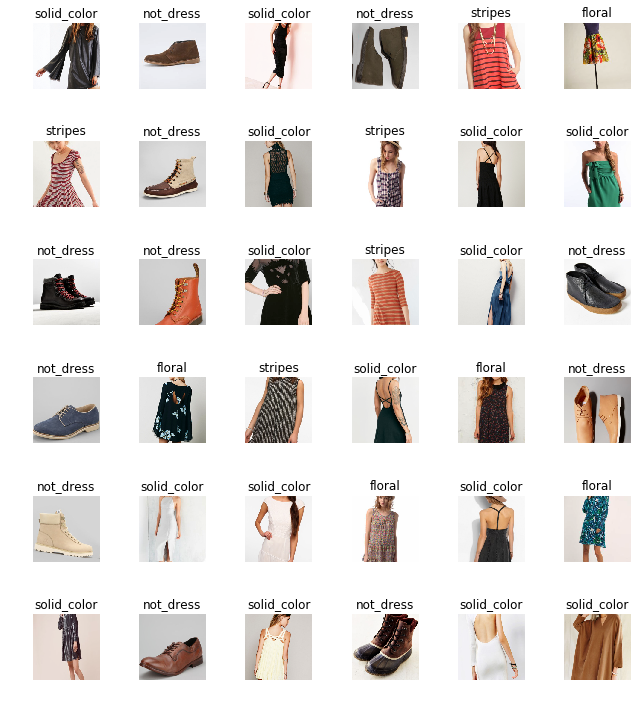

In [7]:
data.show_batch(rows=6)

## Train a standard transfer learning model (stage 1)

epoch,train_loss,valid_loss,error_rate
1,0.928811,0.457915,0.147059
2,0.576249,0.336673,0.102941
3,0.421974,0.290211,0.097426
4,0.359036,0.271983,0.093750
5,0.300393,0.262434,0.086397
6,0.263033,0.241389,0.084559
7,0.277091,0.242457,0.080882
8,0.231246,0.228696,0.075368
9,0.201122,0.233433,0.079044
10,0.175898,0.259085,0.091912


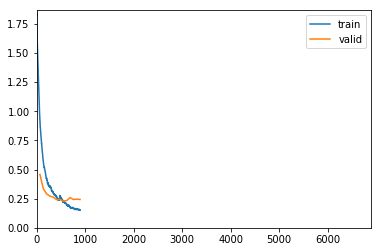

Epoch 13: early stopping


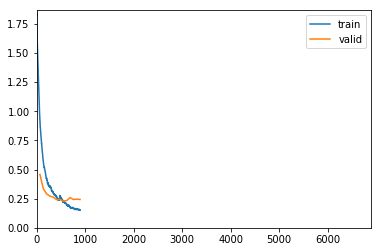

In [8]:
learn = create_learner(data, 'stage1-bestmodel')
learn.fit_one_cycle(n_epoch)

### Show results from generic evaluation tool

In [9]:
results_val = util.eval_rollup(labels_file, learn, evalset='val')

Dataset: val
{'sklearn': {'acc': 0.9246323529411765,
             'auc_avg': 0.9875207212785985,
             'auc_indiv': array([0.985821, 0.998796, 0.982052, 0.983415]),
             'confmat': array([[138,   0,  12,   0],
       [  1,  61,   2,   0],
       [ 10,   0, 267,   2],
       [  6,   0,   8,  37]]),
             'report': '             precision    recall  f1-score   support\n'
                       '\n'
                       '     floral       0.89      0.92      0.90       150\n'
                       '  not_dress       1.00      0.95      0.98        64\n'
                       'solid_color       0.92      0.96      0.94       279\n'
                       '    stripes       0.95      0.73      0.82        51\n'
                       '\n'
                       'avg / total       0.93      0.92      0.92       '
                       '544\n'}}


/home/jupyter/tutorials/util.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_keep['name'] = [d.split('/')[-1] for d in df_keep.name.tolist()]


In [10]:
results_test, y_true, y_pred, scores, class_labels = util.eval_rollup(labels_file, learn, evalset='test')

Dataset: test
{'sklearn': {'acc': 0.926605504587156,
             'auc_avg': 0.9851900290319527,
             'auc_indiv': array([0.985741, 0.977645, 0.983271, 0.994103]),
             'confmat': array([[135,   0,   5,   2],
       [  5,  63,   6,   1],
       [ 13,   1, 266,   4],
       [  1,   0,   2,  41]]),
             'report': '             precision    recall  f1-score   support\n'
                       '\n'
                       '     floral       0.88      0.95      0.91       142\n'
                       '  not_dress       0.98      0.84      0.91        75\n'
                       'solid_color       0.95      0.94      0.94       284\n'
                       '    stripes       0.85      0.93      0.89        44\n'
                       '\n'
                       'avg / total       0.93      0.93      0.93       '
                       '545\n'}}


### Show results using FastAI to confirm matches

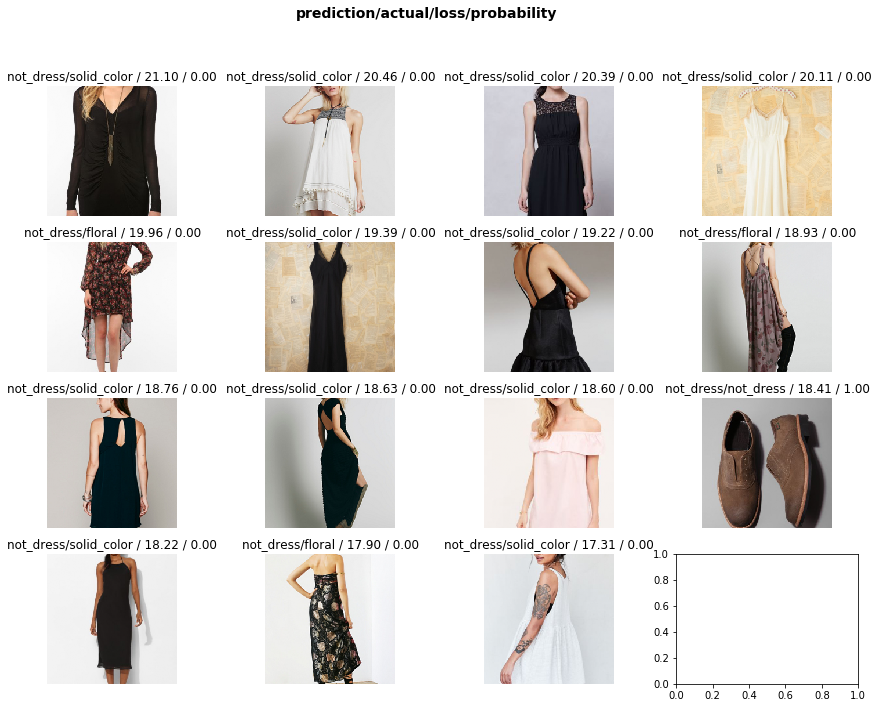

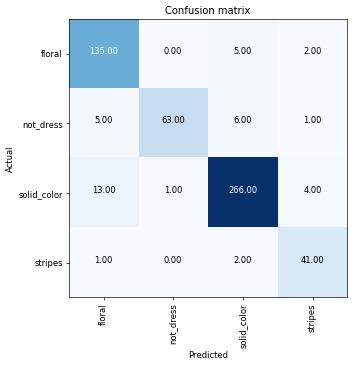

In [11]:
# Confirm fastai reporting matching the generic one used for other platforms
# Some formatting work needed below to run on test and not validation dataset
y_true_num = tensor([data.classes.index(z) for z in y_true])  # Convert strings to numbers (tensor)
preds,y,losses = learn.get_preds(with_loss=True, is_test=True)
interp = ClassificationInterpretation(data, preds, tensor(y_true_num), losses)
interp.plot_top_losses(15, figsize=(15,11))
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

Fastai confusion matrix matches the generic one for the test dataset.

## Unfreezing, fine-tuning, and learning rates

First let's try just unfreezing the previously trained model and continue running some more training to see how well it can do.

epoch,train_loss,valid_loss,error_rate
1,0.212899,0.255519,0.097426
2,0.153469,0.224421,0.075368
3,0.154114,0.323202,0.082721
4,0.150317,0.267049,0.084559
5,0.138249,0.274833,0.090074
6,0.142363,0.290292,0.099265
7,0.158350,0.280466,0.090074
8,0.158044,0.342325,0.091912
9,0.161508,0.307332,0.095588


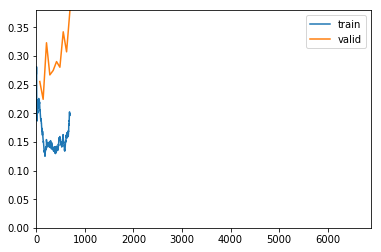

Epoch 10: early stopping


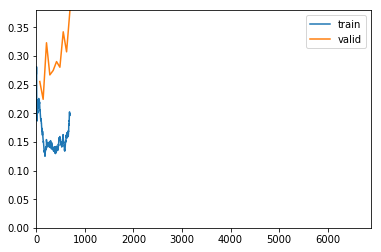

In [56]:
learn = create_learner(data, 'unfreeze-bestmodel')
learn.load('stage1-bestmodel')
learn.unfreeze()
learn.fit_one_cycle(n_epoch)

In [57]:
results_test, y_true, y_pred, scores, class_labels = util.eval_rollup(labels_file, learn, evalset='test')

Dataset: test
{'sklearn': {'acc': 0.926605504587156,
             'auc_avg': 0.9843160037348149,
             'auc_indiv': array([0.986344, 0.973418, 0.984715, 0.992787]),
             'confmat': array([[131,   0,   9,   2],
       [  3,  64,   8,   0],
       [ 13,   1, 269,   1],
       [  2,   0,   1,  41]]),
             'report': '             precision    recall  f1-score   support\n'
                       '\n'
                       '     floral       0.88      0.92      0.90       142\n'
                       '  not_dress       0.98      0.85      0.91        75\n'
                       'solid_color       0.94      0.95      0.94       284\n'
                       '    stripes       0.93      0.93      0.93        44\n'
                       '\n'
                       'avg / total       0.93      0.93      0.93       '
                       '545\n'}}


/home/jupyter/tutorials/util.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_keep['name'] = [d.split('/')[-1] for d in df_keep.name.tolist()]


## Unfreeze but use identified learning rates

Now let's go back to the original model that only trained the head again. 
But this time, we'll find the best learning rate to use for this, and then use those learning rates with the unfrozen model.

First, find and plot the learning rates using lr_find.

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


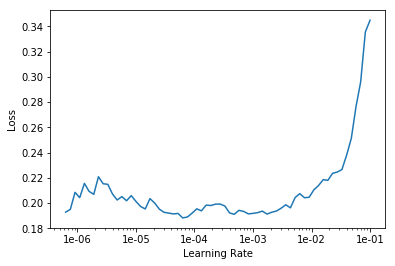

In [19]:
learn = create_learner(data)
learn.load('stage1-bestmodel')
learn.callback_fns = [Recorder]  # Need to flush callbacks or else lr_find crashes    
learn.lr_find()
learn.recorder.plot()

Now that we have the learning rate range, let's feed that into the model and rerun

epoch,train_loss,valid_loss,error_rate
1,0.180553,0.231527,0.079044
2,0.167680,0.228687,0.079044
3,0.161569,0.236289,0.086397
4,0.143908,0.241076,0.080882
5,0.117038,0.231042,0.071691
6,0.108769,0.252501,0.084559
7,0.091657,0.245073,0.071691
8,0.081800,0.268605,0.080882
9,0.069420,0.283909,0.080882


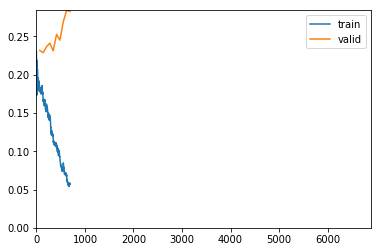

Epoch 10: early stopping


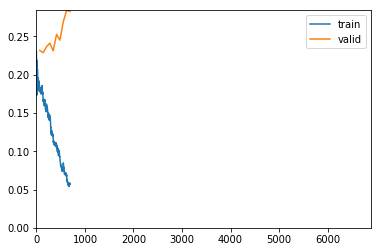

In [22]:
# Reload with new savename
learn = create_learner(data, 'stage2-bestmodel')
learn.load('stage1-bestmodel')

# Unfreeze and kick off 
learn.unfreeze()
learn.fit_one_cycle(n_epoch, max_lr=slice(1e-5,1e-3))

In [23]:
results_test, y_true, y_pred, scores, class_labels = util.eval_rollup(labels_file, learn, evalset='test')

Dataset: test
{'sklearn': {'acc': 0.926605504587156,
             'auc_avg': 0.985919421159572,
             'auc_indiv': array([0.986405, 0.978184, 0.98485 , 0.994239]),
             'confmat': array([[134,   0,   5,   3],
       [  4,  64,   6,   1],
       [ 14,   1, 266,   3],
       [  2,   0,   1,  41]]),
             'report': '             precision    recall  f1-score   support\n'
                       '\n'
                       '     floral       0.87      0.94      0.91       142\n'
                       '  not_dress       0.98      0.85      0.91        75\n'
                       'solid_color       0.96      0.94      0.95       284\n'
                       '    stripes       0.85      0.93      0.89        44\n'
                       '\n'
                       'avg / total       0.93      0.93      0.93       '
                       '545\n'}}


## Try Resnet50

In [24]:
data = ImageDataBunch.from_folder(path_img, 
                                  train='train', 
                                  valid='valid', 
                                  test='test', 
                                  ds_tfms=get_transforms(), 
                                  size=299,
                                  bs=32)
data.normalize(imagenet_stats)

### Try training just the head

epoch,train_loss,valid_loss,error_rate
1,0.468465,0.287810,0.084559
2,0.329154,0.254921,0.086397
3,0.266084,0.230838,0.080882
4,0.219798,0.213842,0.075368
5,0.199969,0.215420,0.079044
6,0.210217,0.224645,0.077206
7,0.177864,0.210861,0.073529
8,0.163686,0.229194,0.064338
9,0.158306,0.214422,0.077206
10,0.137121,0.238942,0.073529


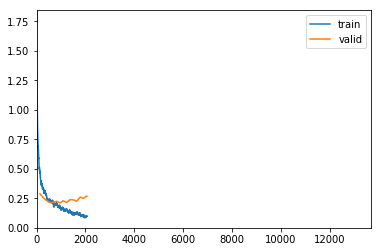

Epoch 15: early stopping


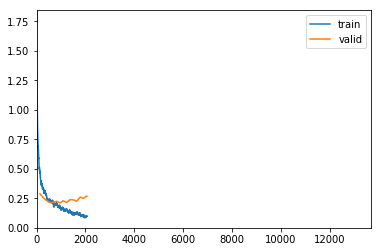

In [29]:
learn = create_learner(data, 'resnet50-stage1-bestmodel', modeltype=models.resnet50)
learn.fit_one_cycle(n_epoch)

In [30]:
results_test, y_true, y_pred, scores, class_labels = util.eval_rollup(labels_file, learn, evalset='test')

Dataset: test
{'sklearn': {'acc': 0.926605504587156,
             'auc_avg': 0.9799659657453513,
             'auc_indiv': array([0.986702, 0.951433, 0.984769, 0.996961]),
             'confmat': array([[132,   0,   8,   2],
       [  3,  63,   9,   0],
       [ 10,   0, 272,   2],
       [  1,   0,   5,  38]]),
             'report': '             precision    recall  f1-score   support\n'
                       '\n'
                       '     floral       0.90      0.93      0.92       142\n'
                       '  not_dress       1.00      0.84      0.91        75\n'
                       'solid_color       0.93      0.96      0.94       284\n'
                       '    stripes       0.90      0.86      0.88        44\n'
                       '\n'
                       'avg / total       0.93      0.93      0.93       '
                       '545\n'}}


/home/jupyter/tutorials/util.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_keep['name'] = [d.split('/')[-1] for d in df_keep.name.tolist()]


### Unfreeze, finetune with learning rates

Get the learning rate separately, like before

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


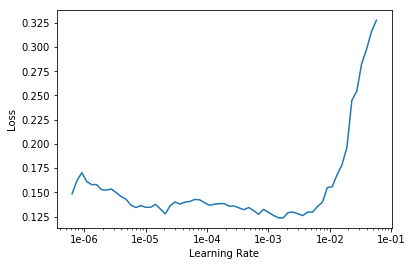

In [34]:
learn = create_learner(data, modeltype=models.resnet50)
learn.load('resnet50-stage1-bestmodel')
learn.callback_fns = [Recorder]  # Need to flush callbacks or else lr_find crashes    
learn.lr_find()
learn.recorder.plot()

Reload the transfer learning results, unfreeze, and train using the range of learning rates.

epoch,train_loss,valid_loss,error_rate
1,0.146622,0.219020,0.080882
2,0.132143,0.216019,0.077206
3,0.126370,0.209346,0.071691
4,0.121646,0.208239,0.071691
5,0.131120,0.214694,0.071691
6,0.112422,0.214792,0.071691
7,0.102617,0.216855,0.073529
8,0.106326,0.235673,0.080882
9,0.105084,0.223962,0.069853
10,0.083951,0.225829,0.075368


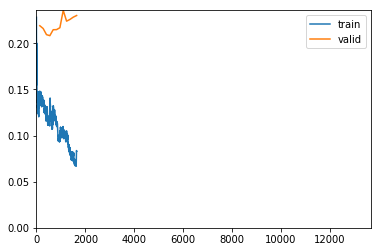

Epoch 12: early stopping


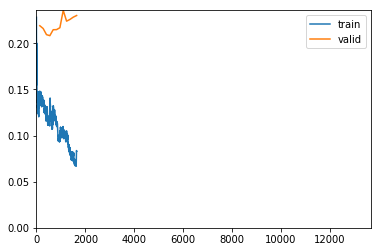

In [37]:
# Reload with new savename
learn = create_learner(data, 'resnet50-stage2-bestmodel', modeltype=models.resnet50)
learn.load('resnet50-stage1-bestmodel')

# Unfreeze and kick off 
learn.unfreeze()
learn.fit_one_cycle(n_epoch, max_lr=slice(1e-6,1e-4))

In [38]:
results_test, y_true, y_pred, scores, class_labels = util.eval_rollup(labels_file, learn, evalset='test')

Dataset: test
{'sklearn': {'acc': 0.9357798165137615,
             'auc_avg': 0.9805835499538551,
             'auc_indiv': array([0.985688, 0.953078, 0.986698, 0.99687 ]),
             'confmat': array([[132,   0,   6,   4],
       [  3,  65,   7,   0],
       [  8,   0, 274,   2],
       [  0,   0,   5,  39]]),
             'report': '             precision    recall  f1-score   support\n'
                       '\n'
                       '     floral       0.92      0.93      0.93       142\n'
                       '  not_dress       1.00      0.87      0.93        75\n'
                       'solid_color       0.94      0.96      0.95       284\n'
                       '    stripes       0.87      0.89      0.88        44\n'
                       '\n'
                       'avg / total       0.94      0.94      0.94       '
                       '545\n'}}
